# Code to plot figures with Science Journal's specific guidelines
## Imports

In [1]:
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

%matplotlib notebook

# You may need to do some specific stuff to make Helvetica accessible to matplotlib
# Just setting the font is not enough, since sometimes matplotlib quietly ignores
# a missing font - the assert is to make sure you are using Helvetica
sns.set(font="Helvetica")
from matplotlib.font_manager import findfont, FontProperties
assert("helvetica" in findfont(FontProperties(family=plt.rcParams['font.family'])).lower())

## Settings for final outputs

In [2]:
SAVE_ALL_FIGS = True
OUTPUT_DIR = "../plots"

# We have the following directory structure
# - Plot 1
#     - Type 1 (3 Plots) # One for each task
#     - Type 2 (5 Plots) # One for Morphology, One for Syntax, Three for Semantics
#     - Type 3 (7 Plots) # Two for Morphology, Two for Syntax, Three for Semantics
# - Plot 2 # 5 plots, 2 for Syntax, 3 for Semantics
# - Plot 3 # 5 plots, 2 for Syntax, 3 for Semantics

if SAVE_ALL_FIGS:
    plot1_type1_path = os.path.join(os.path.join(OUTPUT_DIR, "Plot 1"), "Type 1 (3 Plots)")
    plot1_type2_path = os.path.join(os.path.join(OUTPUT_DIR, "Plot 1"), "Type 2 (5 Plots)")
    plot1_type3_path = os.path.join(os.path.join(OUTPUT_DIR, "Plot 1"), "Type 3 (7 Plots)")
    plot2_path = os.path.join(OUTPUT_DIR, "Plot 2")
    plot3_path = os.path.join(OUTPUT_DIR, "Plot 3")

    for p in [plot1_type1_path, plot1_type2_path, plot1_type3_path, plot2_path, plot3_path]:
        if not os.path.exists(p):
            os.makedirs(p)

In [3]:
def load_data(filename, sep='\t'):
    df = pd.read_csv(filename, sep=sep)
    df['mean'] = np.mean([df['acc1'], df['acc2'], df['acc3']], axis=0)
    df['std'] = np.std([df['acc1'], df['acc2'], df['acc3']], axis=0)
    return df

def load_data_by_type_all(filename, sep='\t', scale=100):
    """ Load data for all language pairs by type

    Convert types from column to values of a "relation" column
    Empty cells are possible and they are non-existing types in the language, so they will not have corresponding rows
    """

    layers, sources, targets, runs, relations, accs = [], [], [], [], [], []
    header, types = None, None
    with open(filename) as f:
        for line in f:
            splt = line.strip('\n').split('\t')
            if header == None:
                header = splt
                types = splt[4:] 
                continue
            layer, source, target, run = splt[:4]
            for relation, acc in zip(types, splt[4:]):
                if acc != '':
                    layers.append(layer)
                    sources.append(source)
                    targets.append(target)
                    runs.append(run)
                    relations.append(relation)
                    accs.append(float(acc)*scale)
    df = pd.DataFrame({'layer': layers, 'source': sources, 'target': targets, 'run': runs, 'relation': relations, 'accuracy': accs})
    return df

def load_data_by_distance(filename, sep='\t', scale=100):
    
    df = pd.read_csv(filename, sep=sep)
    dists = [col for col in df.columns if col.startswith('dist')]
    for dist in dists:
        df[dist] *= scale
    return df


def rgba(r,g,b,a=1.0):
    return (r/255.0, g/255.0, b/255.0, a)

In [4]:
def plot_lines_with_minmax_area(datas, linecolors, areacolors, labels, title, x_label, y_label, ylims=None, order=None):
    line_handles = []
    for idx, data in enumerate(datas):
        max_line_data = data.groupby('layer').max().reset_index()
        min_line_data = data.groupby('layer').min().reset_index()
        sns.pointplot(x="layer", y="mean", data=max_line_data, ci=None, markers='', linestyles='')
        ax = sns.pointplot(x="layer", y="mean", data=min_line_data, ci=None, markers='', linestyles='')
        ax.fill_between(max_line_data['layer'], max_line_data['mean'], min_line_data['mean'], color=areacolors[idx], linewidth=0, interpolate=True)
        sns.pointplot(x="layer", y="mean", data=data, ci=None, color=linecolors[idx], label="*-to-en")
        line_handles.append(ax.lines[-1])
    
    ax.set_ylim([ax.get_ylim()[0],100])

    # Rearrange line handles if necessary
    if order:
        new_line_handles = []
        new_labels = []
        for e in order:
            new_line_handles.append(line_handles[e])
            new_labels.append(labels[e])
        line_handles = new_line_handles
        labels = new_labels


    l = ax.legend(handles=line_handles, labels=labels, title=title, frameon=True, fancybox=True, framealpha=0.8, facecolor="#FFFFFF")
    plt.setp(l.get_title(), multialignment='center')
    ax.set_ylabel("Average accuracy")
    ax.set_xlabel("Layer")

    plt.show()

def plot_lines_with_std_area(datas, linecolors, areacolors, labels, title, x_label, y_label, ylims=None, order=None, hatches=None):
    line_handles = []
    for idx, data in enumerate(datas):
        avg_data = data.groupby('layer').mean().reset_index()
        avg_data['upper'] = data.groupby('layer').mean()['mean'] + data.groupby('layer').std()['mean'] 
        avg_data['lower'] = data.groupby('layer').mean()['mean'] - data.groupby('layer').std()['mean']
        sns.pointplot(x="layer", y="upper", data=avg_data, ci=None, markers='', linestyles='')
        ax = sns.pointplot(x="layer", y="lower",data=avg_data, ci=None, markers='', linestyles='')
        if hatches:
            ax.fill_between(avg_data['layer'], avg_data['upper'], avg_data['lower'], edgecolor=linecolors[idx], facecolor="none", linewidth=0.1, interpolate=True, hatch=hatches[idx])
        else:
            ax.fill_between(avg_data['layer'], avg_data['upper'], avg_data['lower'], color=areacolors[idx], linewidth=0, interpolate=True)
        sns.pointplot(x="layer", y="mean", data=avg_data, ci=None, color=linecolors[idx], label="*-to-en")
        line_handles.append(ax.lines[-1])
    
    if ylims:
        ax.set_ylim(list(ylims))
    else:
        ax.set_ylim([ax.get_ylim()[0],100])
        
    # Rearrange line handles if necessary
    if order:
        new_line_handles = []
        new_labels = []
        for e in order:
            new_line_handles.append(line_handles[e])
            new_labels.append(labels[e])
        line_handles = new_line_handles
        labels = new_labels

    l = ax.legend(handles=line_handles, labels=labels, title=title, frameon=True, fancybox=True, framealpha=0.8, facecolor="#FFFFFF")
    plt.setp(l.get_title(), multialignment='center')
    ax.set_ylabel("Average accuracy")
    ax.set_xlabel("Layer")

    plt.show()

    
def horizontal_plot_lines_with_std_area(datas, linecolors, areacolors, labels, title, x_label, y_label, ylims=None, order=None, hatches=None):
    num_plots = len(datas)
    f, horiz_ax = plt.subplots(1, num_plots, sharey=True, figsize=(5*num_plots, 4))

    line_handles = []
    for idx, data in enumerate(datas):
        plt.sca(horiz_ax[idx])
        avg_data = data.groupby('layer').mean().reset_index()
        avg_data['upper'] = data.groupby('layer').mean()['mean'] + data.groupby('layer').std()['mean'] 
        avg_data['lower'] = data.groupby('layer').mean()['mean'] - data.groupby('layer').std()['mean']
        sns.pointplot(x="layer", y="upper", data=avg_data, ci=None, markers='', linestyles='')
        ax = sns.pointplot(x="layer", y="lower",data=avg_data, ci=None, markers='', linestyles='')
        if hatches:
            ax.fill_between(avg_data['layer'], avg_data['upper'], avg_data['lower'], edgecolor=linecolors[idx], facecolor="none", linewidth=0.1, interpolate=True, hatch=hatches[idx])
        else:
            ax.fill_between(avg_data['layer'], avg_data['upper'], avg_data['lower'], color=areacolors[idx], linewidth=0, interpolate=True)
        sns.pointplot(x="layer", y="mean", data=avg_data, ci=None, color=linecolors[idx], label="*-to-en")
        line_handles.append(ax.lines[-1])
        horiz_ax[idx].set_ylabel("")
        horiz_ax[idx].set_xlabel("Layer")
#         horiz_ax[idx].legend(handles=[ax.lines[-1]], labels=[labels[idx]], title=title, frameon=True, fancybox=True, framealpha=0.8, facecolor="#FFFFFF")
    
    if ylims:
        horiz_ax[0].set_ylim(list(ylims))
    else:
        horiz_ax[0].set_ylim([ax.get_ylim()[0],100])

    # Rearrange line handles if necessary
    if order:
        new_line_handles = []
        new_labels = []
        for e in order:
            new_line_handles.append(line_handles[e])
            new_labels.append(labels[e])
        line_handles = new_line_handles
        labels = new_labels

    l = horiz_ax[-1].legend(handles=line_handles, labels=labels, title=title, frameon=True, fancybox=True, framealpha=0.8, facecolor="#FFFFFF")
    plt.setp(l.get_title(), multialignment='center')
    horiz_ax[0].set_ylabel("Average accuracy")
    
    plt.subplots_adjust(wspace=0.01, hspace=0)
    plt.show()

In [5]:
sns.set(style="darkgrid")

# Morphological Tagging Plot

In [6]:
data = load_data("../results/results-un-morph-plot.txt")
en_source_data = data[(data.source=="en") & (data.target!="en")]
en_target_data = data[(data.source!="en") & (data.target=="en")]

<IPython.core.display.Javascript object>


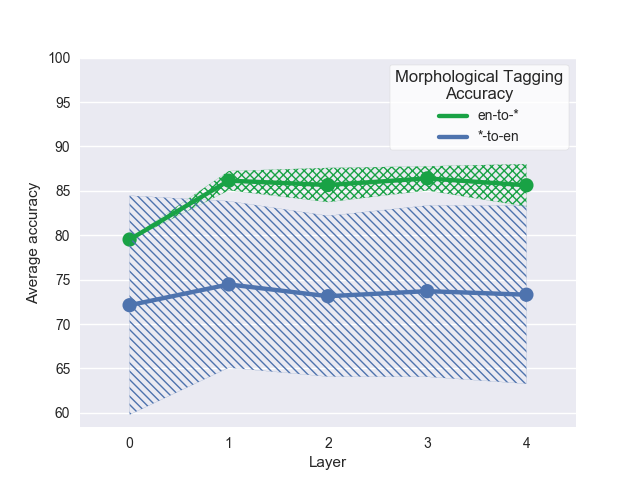

In [7]:
plt.figure()
plot_lines_with_std_area(
    [en_source_data, en_target_data],
    ["#19A245", rgba(78,115,174)],
    [rgba(148,207,167,0.7), rgba(150,202,255,0.7)],
    ['en-to-*', '*-to-en'],
    "Morphological Tagging\nAccuracy",
    "Layer",
    "Average accuracy",
    hatches=["xxxx", "\\\\\\\\"])
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot1_type1_path, "morph.svg"), bbox_inches="tight")
    plt.savefig(os.path.join(plot1_type2_path, "morph.svg"), bbox_inches="tight")

<IPython.core.display.Javascript object>


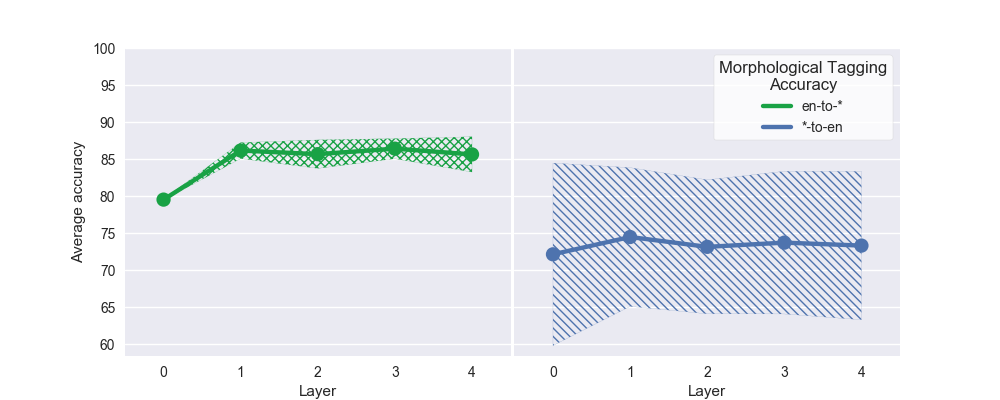

In [8]:
horizontal_plot_lines_with_std_area(
    [en_source_data, en_target_data],
    ["#19A245", rgba(78,115,174)],
    [rgba(148,207,167,0.7), rgba(150,202,255,0.7)],
    ['en-to-*', '*-to-en'],
    "Morphological Tagging\nAccuracy",
    "Layer",
    "Average accuracy",
    hatches=["xxxx", "\\\\\\\\"])
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot1_type3_path, "morph.svg"), bbox_inches="tight")

# Syntax Plot

<IPython.core.display.Javascript object>


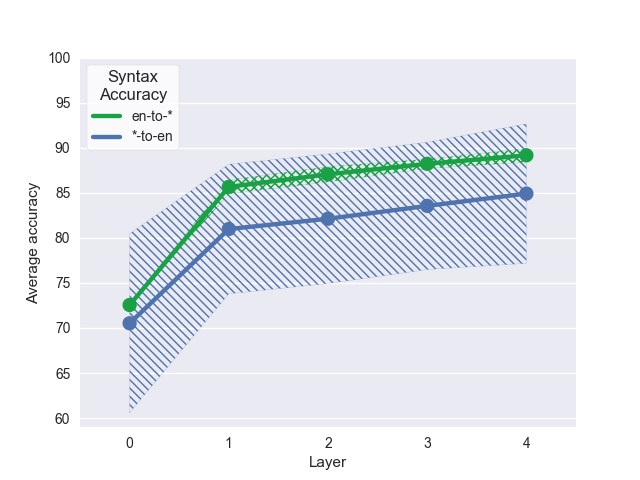

In [9]:
data = load_data("../results/results-un-deprel-plot.txt")
en_source_data = data[(data.source=="en") & (data.target!="en")]
en_target_data = data[(data.source!="en") & (data.target=="en")]
plt.figure()
plot_lines_with_std_area(
    [en_target_data, en_source_data],
    [rgba(78,115,174), rgba(25,162,69)],
    [rgba(150,202,255,0.7), rgba(25,162,69,0.4)],
    ['*-to-en', 'en-to-*'],
    "Syntax\nAccuracy",
    "Layer",
    "Average accuracy",
    order=[1,0],
    hatches=["\\\\\\\\", "xxxx"])
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot1_type1_path, "syntax.svg"), bbox_inches="tight")
    plt.savefig(os.path.join(plot1_type2_path, "syntax.svg"), bbox_inches="tight")

<IPython.core.display.Javascript object>


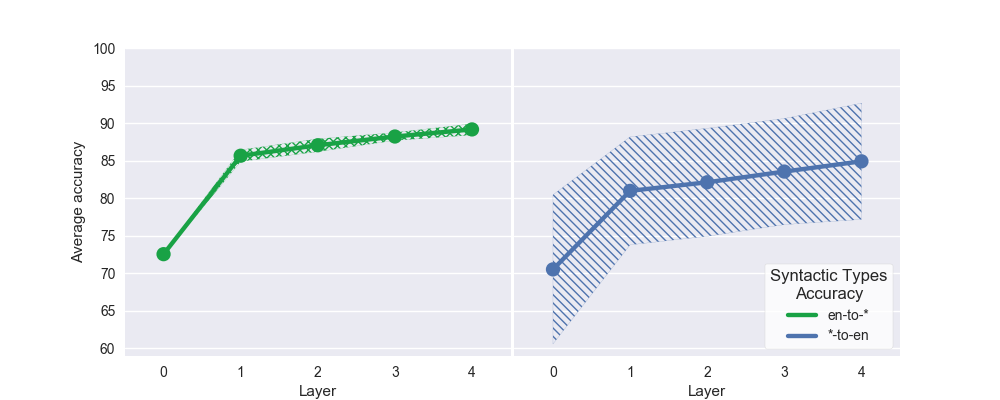

In [10]:
horizontal_plot_lines_with_std_area(
    [en_source_data, en_target_data],
    [rgba(25,162,69), rgba(78,115,174)],
    [rgba(25,162,69,0.4), rgba(150,202,255,0.7)],
    ['en-to-*', '*-to-en'],
    "Syntactic Types\nAccuracy",
    "Layer",
    "Average accuracy",
    hatches=["xxxx", "\\\\\\\\"])
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot1_type3_path, "syntax.svg"), bbox_inches="tight")

# Semantics Plot

<IPython.core.display.Javascript object>


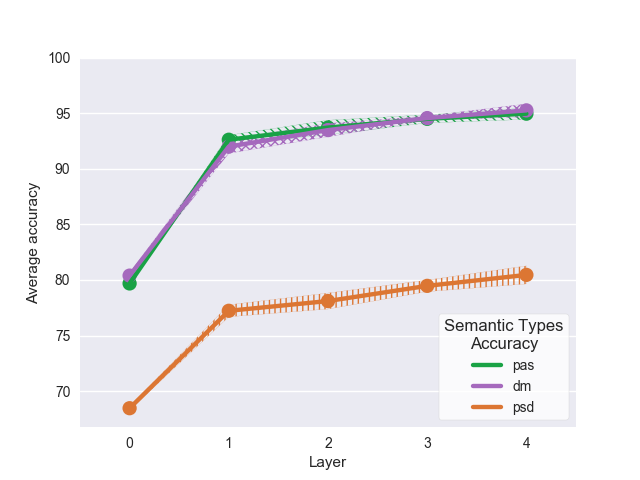

In [11]:
data = load_data("../results/results-un-semdeprel-pas-plot.txt")
pas_source_data = data[(data.source=="en") & (data.target!="en")]
data = load_data("../results/results-un-semdeprel-dm-plot.txt")
dm_source_data = data[(data.source=="en") & (data.target!="en")]
data = load_data("../results/results-un-semdeprel-psd-plot.txt")
psd_source_data = data[(data.source=="en") & (data.target!="en")]

plt.figure()
plot_lines_with_std_area(
    [pas_source_data, dm_source_data, psd_source_data],
    [rgba(25,162,69), rgba(165,105,189), rgba(220,118,51)],
    [rgba(25,162,69,0.4), rgba(183,151,196,0.7), rgba(220,150,104,0.7)],
    ['pas', 'dm', 'psd'],
    "Semantic Types\nAccuracy",
    "Layer",
    "Average accuracy",
    hatches=["\\\\\\\\", "xxxx", "|||"])

if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot1_type1_path, "semantic.svg"), bbox_inches="tight")

<IPython.core.display.Javascript object>


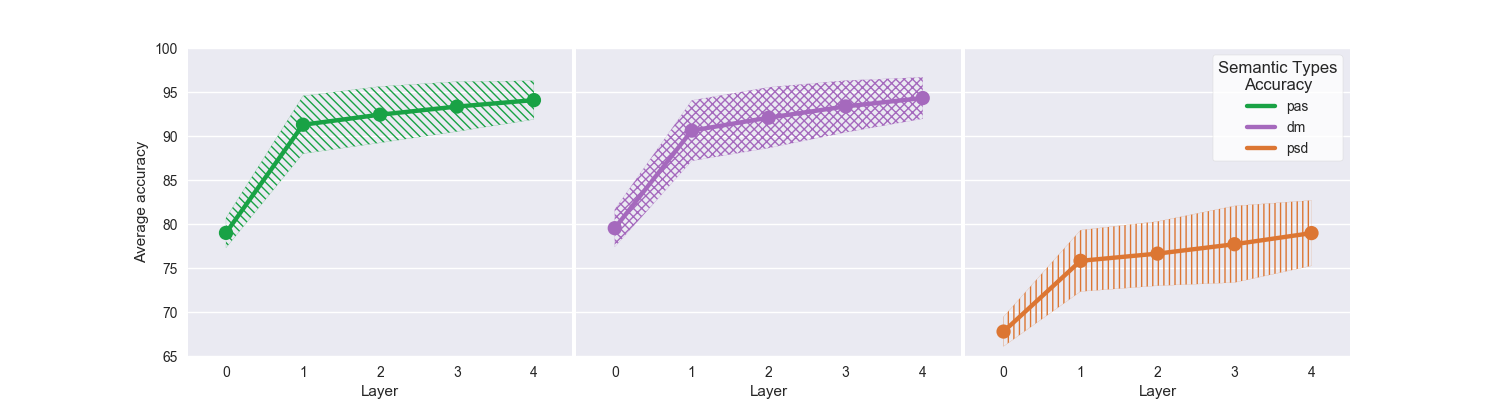

In [12]:
pas_data = load_data("../results/results-un-semdeprel-pas-plot.txt")
pas_data['type'] = 'pas'
dm_data = load_data("../results/results-un-semdeprel-dm-plot.txt")
dm_data['type'] = 'dm'
psd_data = load_data("../results/results-un-semdeprel-psd-plot.txt")
psd_data['type'] = 'psd'
# data = pd.concat([pas_data, dm_data, psd_data], ignore_index=True)
# data = data[(data.source=="en") & (data.target!="en")]

horizontal_plot_lines_with_std_area(
    [pas_data, dm_data, psd_data],
    [rgba(25,162,69), rgba(165,105,189), rgba(220,118,51)],
    [rgba(25,162,69,0.4), rgba(183,151,196,0.7), rgba(220,150,104,0.7)],
    ['pas', 'dm', 'psd'],
    "Semantic Types\nAccuracy",
    "Layer",
    "Average accuracy",
    ylims=(65, 100),
    hatches=["\\\\\\\\", "xxxx", "|||"])
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot1_type2_path, "semantic.svg"), bbox_inches="tight")
    plt.savefig(os.path.join(plot1_type3_path, "semantic.svg"), bbox_inches="tight")

------------------------------
# Plot 2

In [13]:
def plot_types(data, labels, title, xlabel, ylabel, figsize=None, sort=True):
    relations = data['relation'].unique()
    
    ax = None
    if figsize:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        plt.figure()
        ax = plt.gca()

    if sort:
        ax = sns.pointplot(x='accuracy', y='relation', hue='layer', data=data, order=data[(data.layer == '4')].groupby([data.relation]).mean().sort_values(by='accuracy').index.values, join=False, dodge=0.5, scale=0.8, errwidth=2)
    else:
        ax = sns.pointplot(x='accuracy', y='relation', hue='layer', data=data, join=False, dodge=0.5, scale=0.8, errwidth=2)
    for idx, relation in enumerate(relations):
        if idx % 2:
            continue
        ax.add_patch(
            patches.Rectangle(
                (-10, (idx+1)-0.5),   # (x,y)
                50,          # width
                1,          # height
                alpha=0.1
            )
        )
    handles, _ = ax.get_legend_handles_labels() 
    l = ax.legend(title=title, handles=handles, labels=labels, frameon=True, fancybox=True, framealpha=0.8, facecolor="#FFFFFF")
    plt.setp(l.get_title(), multialignment='center')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    

# Syntax by types

<IPython.core.display.Javascript object>


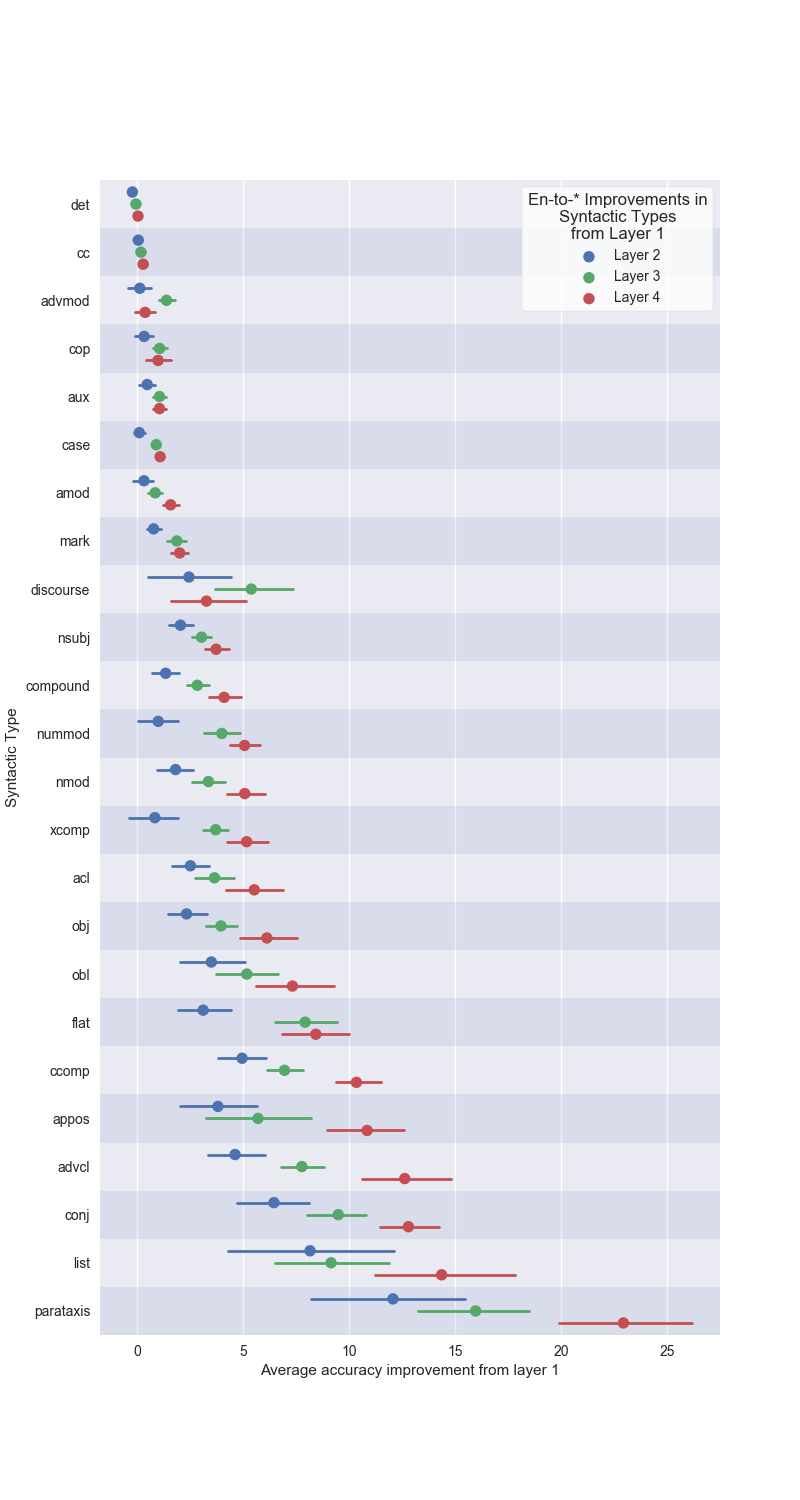

<IPython.core.display.Javascript object>


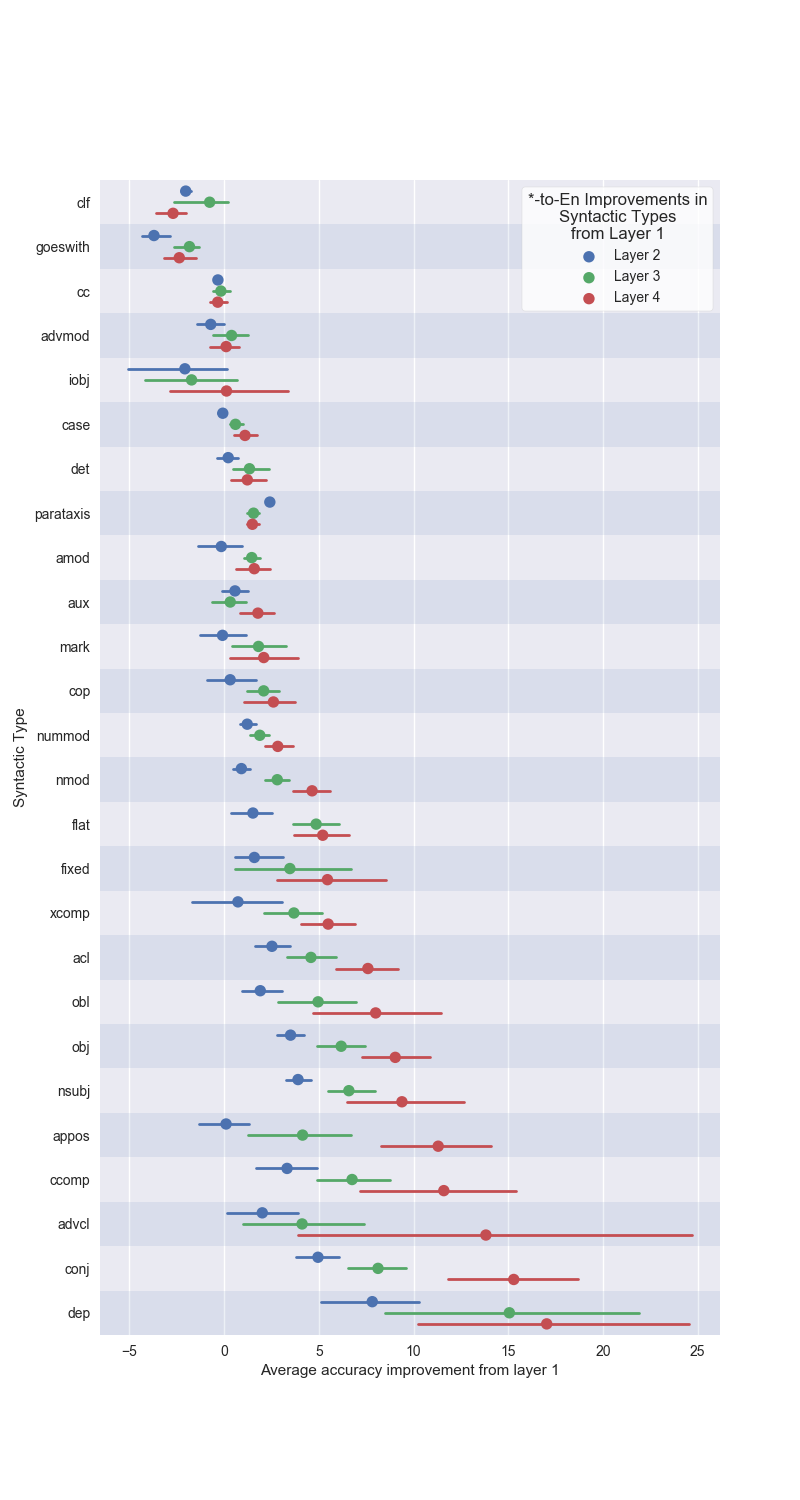

In [14]:
data = load_data_by_type_all('../results/results-un-deprel-types-nopunct-min80-deltas-plot.txt')
en_source_data = data[(data.source=="en") & (data.target!="en")]
en_target_data = data[(data.source!="en") & (data.target=="en")]

plot_types(en_source_data, ["Layer 2", "Layer 3", "Layer 4"], "En-to-* Improvements in\nSyntactic Types\nfrom Layer 1", "Average accuracy improvement from layer 1", "Syntactic Type", figsize=(8, 15))
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot2_path, "syntax_en_to_all.svg"), bbox_inches="tight")

plot_types(en_target_data, ["Layer 2", "Layer 3", "Layer 4"], "*-to-En Improvements in\nSyntactic Types\nfrom Layer 1", "Average accuracy improvement from layer 1", "Syntactic Type", figsize=(8, 15))
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot2_path, "syntax_all_to_en.svg"), bbox_inches="tight")

# Semantics by Type

<IPython.core.display.Javascript object>


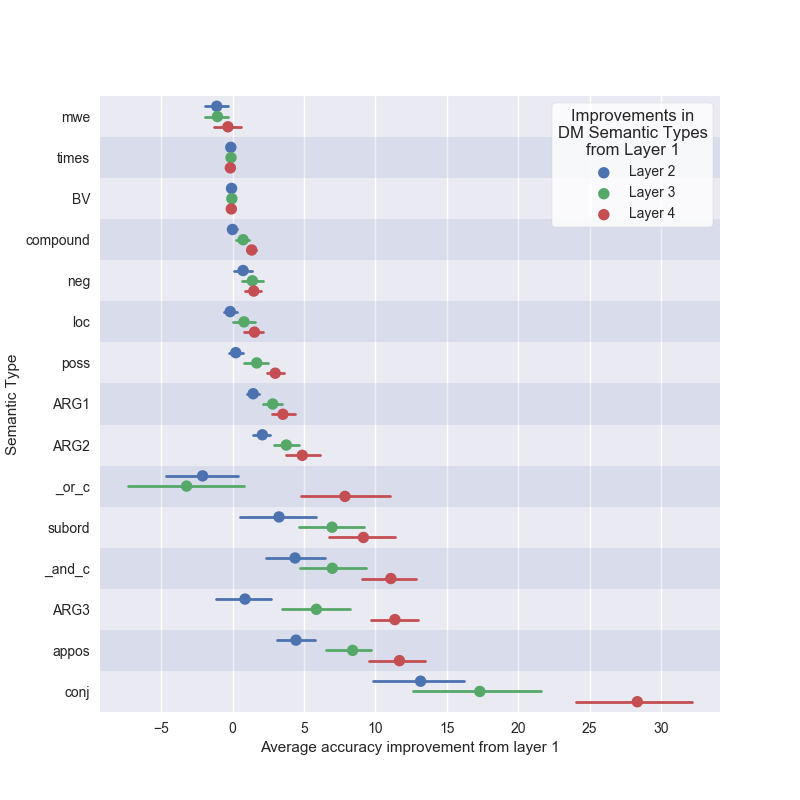

<IPython.core.display.Javascript object>


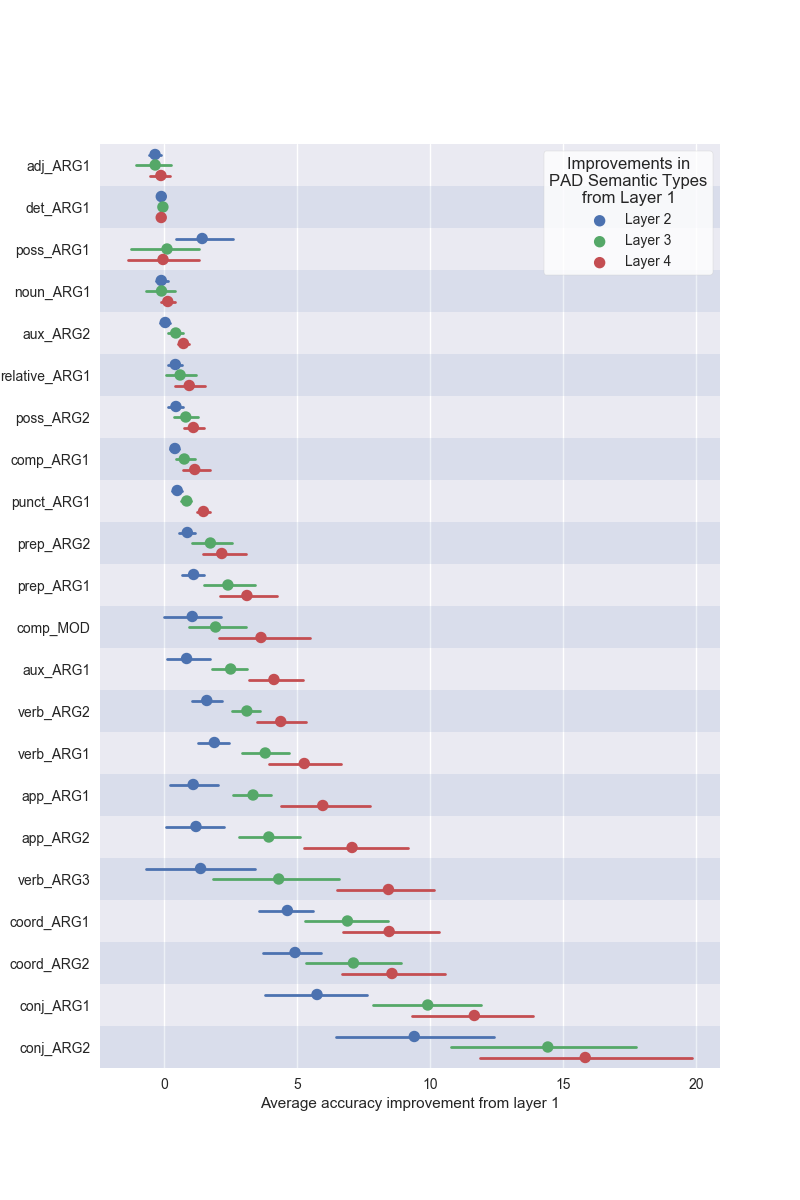

<IPython.core.display.Javascript object>


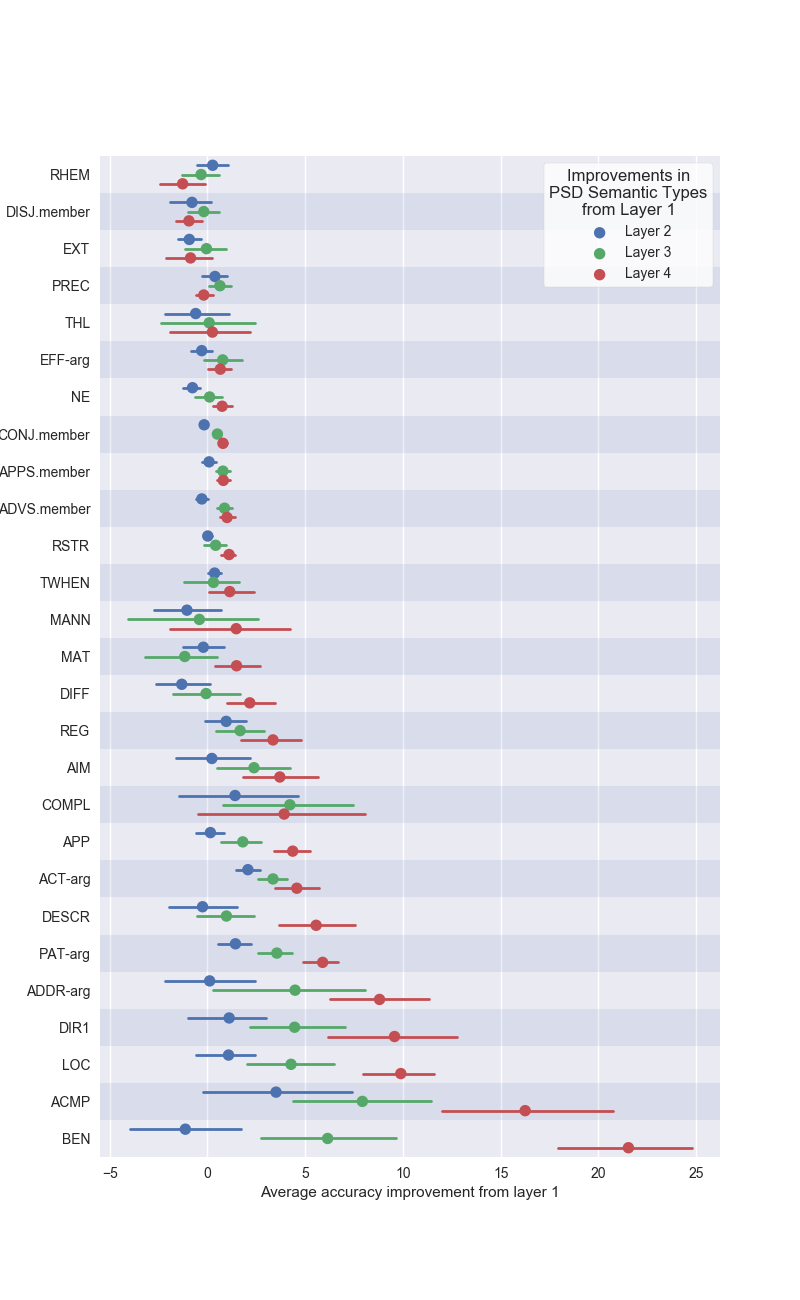

In [15]:
dm_data = load_data_by_type_all('../results/results-un-semdeprel-types-nonull-min100-deltas-plot.txt')
pas_data = load_data_by_type_all('../results/results-un-semdeprel-pas-types-nonull-min100-deltas-plot.txt')
psd_data = load_data_by_type_all('../results/results-un-semdeprel-psd-types-nonull-min100-deltas-plot.txt')

plot_types(dm_data, ["Layer 2", "Layer 3", "Layer 4"], "Improvements in\nDM Semantic Types\nfrom Layer 1", "Average accuracy improvement from layer 1", "Semantic Type", figsize=(8,8))
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot2_path, "semantic_dm.svg"), bbox_inches="tight")

plot_types(pas_data, ["Layer 2", "Layer 3", "Layer 4"], "Improvements in\nPAD Semantic Types\nfrom Layer 1", "Average accuracy improvement from layer 1", "Semantic Type", figsize=(8,12))
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot2_path, "semantic_pas.svg"), bbox_inches="tight")

plot_types(psd_data, ["Layer 2", "Layer 3", "Layer 4"], "Improvements in\nPSD Semantic Types\nfrom Layer 1", "Average accuracy improvement from layer 1", "Semantic Type", figsize=(8,13))
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot2_path, "semantic_psd.svg"), bbox_inches="tight")

------------------------------
# Plot 3

In [16]:
def plot_bar_distances(data, title, xlabel, ylabel, y_lim=None, figsize=None):
    dist_names = ('1', '2', '3', '4', '5', '6-7', '8-10', '>10')

    layers = np.tile(data['layer'].values, (len(dist_names)))
    accs = np.concatenate([data[col].values for col in data.columns if col.startswith('dist')])
    dists = np.concatenate([[dist_names[i]]*75 for i in range(8)])
    df_plot = pd.DataFrame({'layer' : layers, 'accuracy' : accs, 'distance' : dists }) 
    plt.figure(figsize=figsize)
    palette = itertools.cycle(sns.color_palette("colorblind"))
    handles = []
    labels = []
    for layer in range(4,-1,-1):
        ax = sns.barplot(x="distance", y="accuracy", data=df_plot.query('layer==%d'%layer), color = next(palette))
        handles.append(filter(lambda x: isinstance(x, patches.Rectangle), ax.get_children())[-2])
        labels.append("Layer %d"%(layer))
    l = ax.legend(title=title, handles=handles, labels=labels, frameon=True, fancybox=True, framealpha=0.8, facecolor="#FFFFFF")
    plt.setp(l.get_title(), multialignment='center')
    ax.set_ylim(list(y_lim))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_line_distances(data, title, xlabel, ylabel, y_lim=None, figsize=None):
    dist_names = ('1', '2', '3', '4', '5', '6-7', '8-10', '>10')

    layers = np.tile(data['layer'].values, (len(dist_names)))
    accs = np.concatenate([data[col].values for col in data.columns if col.startswith('dist')])
    dists = np.concatenate([[dist_names[i]]*75 for i in range(8)])
    df_plot = pd.DataFrame({'layer' : layers, 'accuracy' : accs, 'distance' : dists }) 
    plt.figure(figsize=figsize)
    ax = sns.pointplot(x="distance", y="accuracy", hue="layer", hue_order=[4,3,2,1,0],data=df_plot, palette="colorblind")
    handles, labels = ax.get_legend_handles_labels()
    labels = ["Layer %d"%i for i in range(4,-1,-1)]
    l = ax.legend(title=title, handles=handles, labels=labels, frameon=True, fancybox=True, framealpha=0.8, facecolor="#FFFFFF")
    plt.setp(l.get_title(), multialignment='center')
    ax.set_ylim(list(y_lim))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

## Syntax plots

<IPython.core.display.Javascript object>


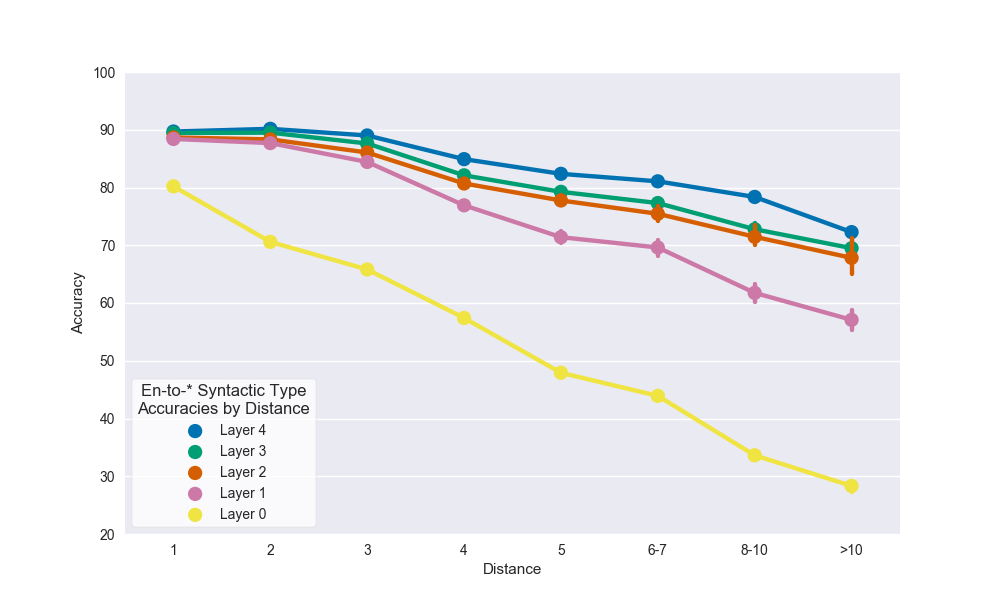

<IPython.core.display.Javascript object>


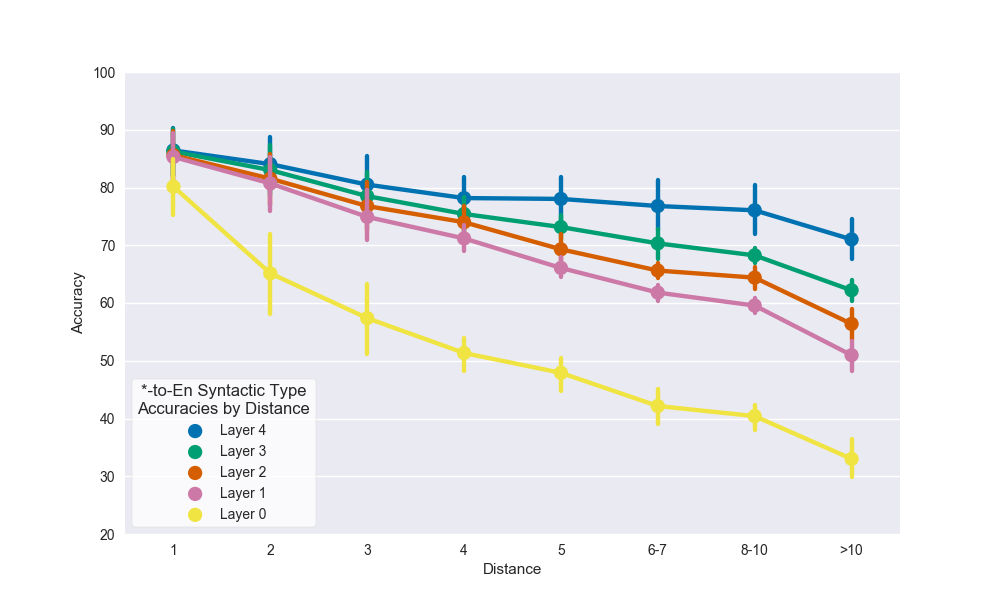

In [17]:
data = load_data_by_distance('../results/results-un-deprel-distance-nopunct-plot.txt')
en_source_data = data[(data.source=="en") & (data.target!="en")]
en_target_data = data[(data.source!="en") & (data.target=="en")]

plot_line_distances(en_source_data, "En-to-* Syntactic Type\nAccuracies by Distance", "Distance", "Accuracy", y_lim=(20, 100), figsize=(10,6))
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot3_path, "syntax_en_to_all.svg"), bbox_inches="tight")
plot_line_distances(en_target_data, "*-to-En Syntactic Type\nAccuracies by Distance", "Distance", "Accuracy", y_lim=(20, 100), figsize=(10,6))
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot3_path, "syntax_all_to_en.svg"), bbox_inches="tight")

## Semantics plot

<IPython.core.display.Javascript object>


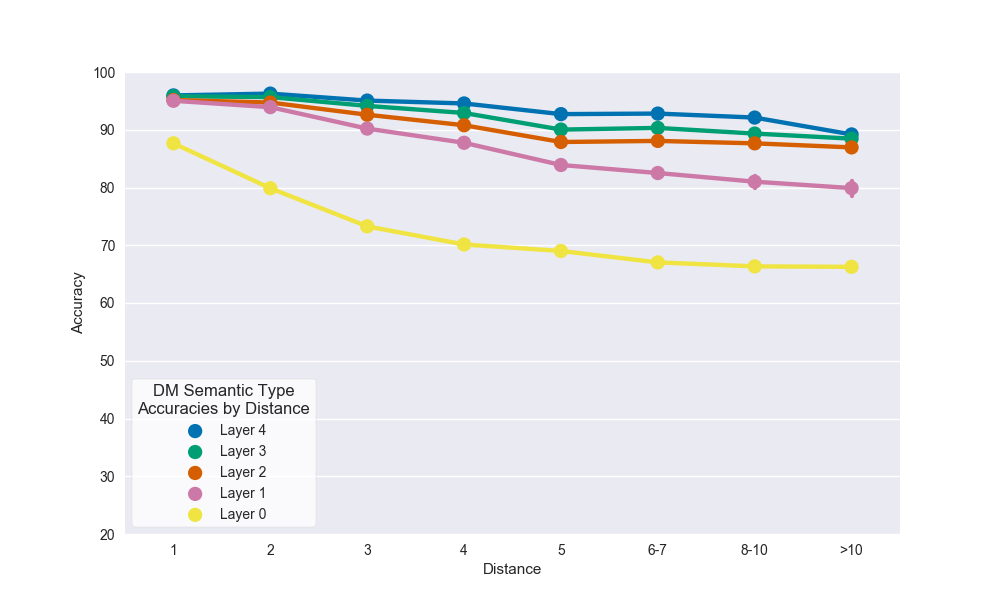

<IPython.core.display.Javascript object>


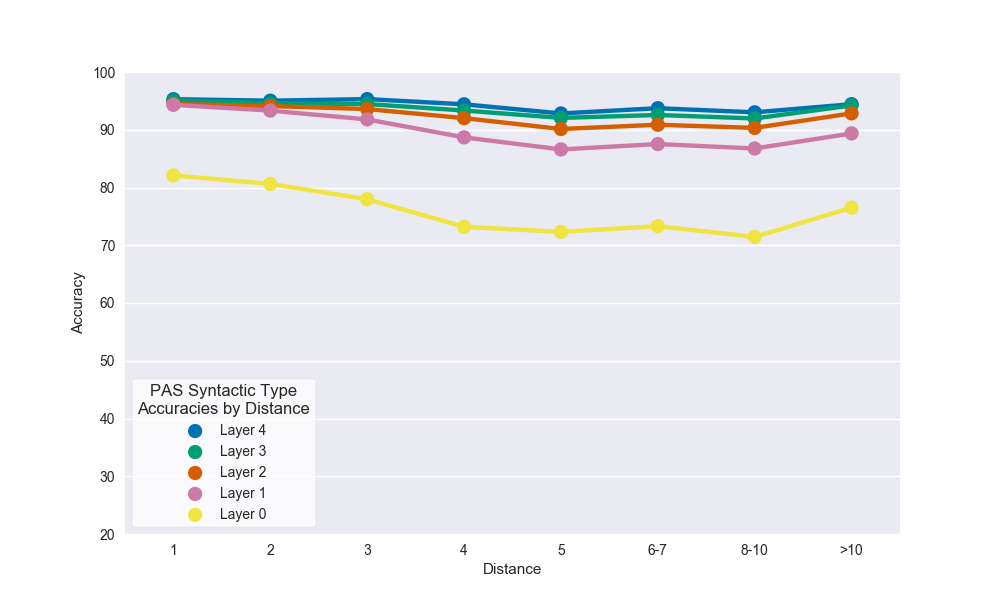

<IPython.core.display.Javascript object>


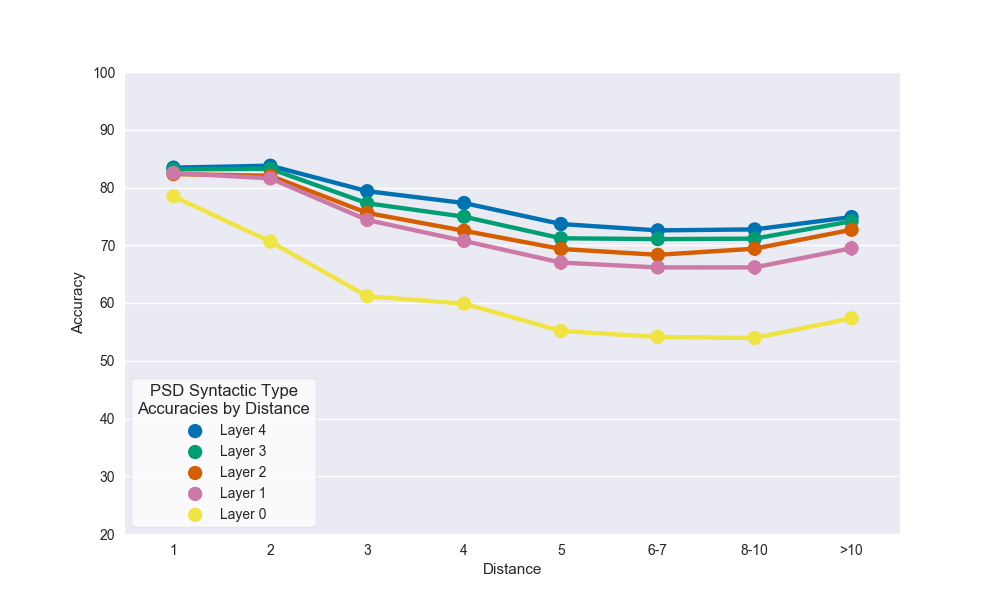

In [18]:
dm_data = load_data_by_distance('../results/results-un-semdeprel-distance-nonull-plot.txt')
pas_data = load_data_by_distance('../results/results-un-semdeprel-pas-distance-nonull-plot.txt')
psd_data = load_data_by_distance('../results/results-un-semdeprel-psd-distance-nonull-plot.txt')

dm_data = dm_data[(dm_data.source=="en") & (dm_data.target!="en")]
pas_data = pas_data[(pas_data.source=="en") & (pas_data.target!="en")]
psd_data = psd_data[(psd_data.source=="en") & (psd_data.target!="en")]
                                               
plot_line_distances(dm_data, "DM Semantic Type\nAccuracies by Distance", "Distance", "Accuracy", y_lim=(20, 100), figsize=(10,6))
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot3_path, "semantic_dm.svg"), bbox_inches="tight")
plot_line_distances(pas_data, "PAS Syntactic Type\nAccuracies by Distance", "Distance", "Accuracy", y_lim=(20, 100), figsize=(10,6))
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot3_path, "semantic_pas.svg"), bbox_inches="tight")
plot_line_distances(psd_data, "PSD Syntactic Type\nAccuracies by Distance", "Distance", "Accuracy", y_lim=(20, 100), figsize=(10,6))
if SAVE_ALL_FIGS:
    plt.savefig(os.path.join(plot3_path, "semantic_psd.svg"), bbox_inches="tight")